# DLS Speech course

## TTS. Seminar 1. 

Author: Sadekova Tasnima

Сегодня будем работать с моделью **Non-attentive Tacotron** (2021) из статьи [Non-Attentive Tacotron: Robust and Controllable Neural TTS Synthesis Including Unsupervised Duration Modeling](https://arxiv.org/abs/2010.04301). 

**github**: https://github.com/JoungheeKim/Non-Attentive-Tacotron

Она является модификацией модели Tacotron2 с заменой механизма внимания на duration predictor блок.

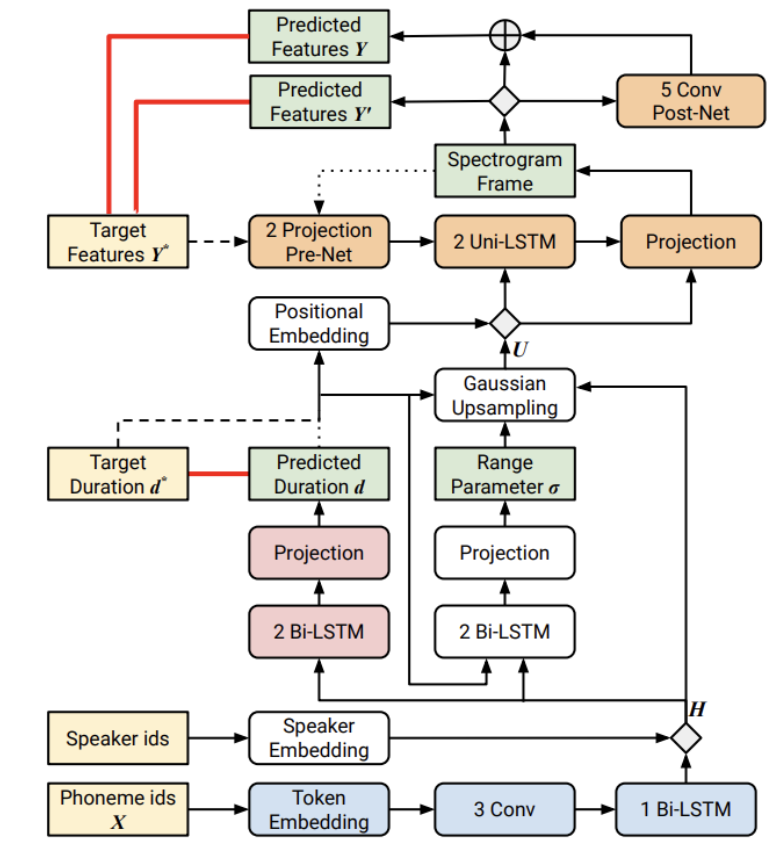

In [150]:
from IPython.display import display, Image
Image('imgs/NAT.png', width=500)

4 основных блока:

1. **Encoder** (красный)
2. **Duration predictor** (зеленый)
3. **Decoder** (синий)
4. **Postnet** (желтый)

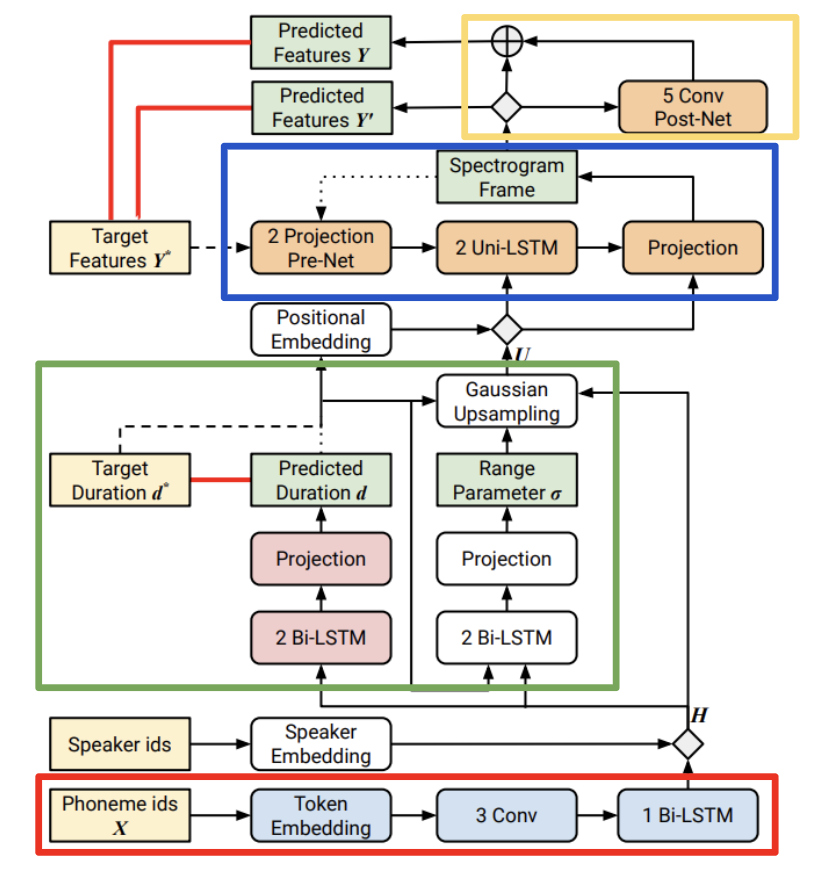

In [149]:
Image('imgs/NAT_blocks.png', width=500)

In [151]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
import math
from dotmap import DotMap
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence


# 1. Encoder

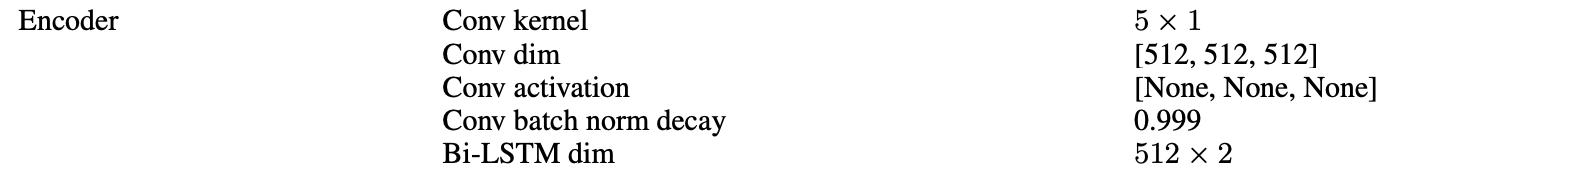

In [152]:
Image('imgs/encoder.png', width=700)

**Input** (phoneme_ids):  X = ($X_1$, $X_2$, ..., $X_{seq\_length}$) , **shape**: (bs x seq_length)


**Output** (encoder_outputs): H = ($H_1$, $H_2$, ..., $H_{seq\_length}$), **shape**:  (bs x seq_length x encoder_hidden_dim)

Будем использовать не фонемы, а **буквы**, как представление текста:

[' ', '<pad>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '’']


Специальные символы
['<pad>', '.', ',', '?', "'", '!']

In [ ]:
cfg = DotMap()

# text representation
cfg.num_labels = 29
cfg.symbols_embedding_dim = 512
cfg.num_special_labels = 6
cfg.symbols_special_embedding_dim = 32

# encoder
cfg.encoder_n_convolutions = 3
cfg.encoder_kernel_size = 5
cfg.encoder_embedding_dim = 512
cfg.encoder_lstm_dim = 512 * 2
cfg.encoder_dropout_p = 0.5
cfg.encoder_activation = "relu"
cfg.encoder_batch_norm_decay = 0.999

### 1.1 Text pre-processing

In [153]:
embedding = nn.Embedding(cfg.num_labels, cfg.symbols_embedding_dim - cfg.symbols_special_embedding_dim)
special_embedding = nn.Embedding(cfg.num_special_labels, cfg.symbols_special_embedding_dim)

In [154]:
bs = 4
seq_length = 30


input_ids = torch.randint(low=0, high=cfg.num_labels-1, size=(bs, seq_length))
special_input_ids = torch.randint(low=0, high=cfg.num_special_labels-1, size=(bs, seq_length))

input_lengths = torch.randint(low=0, high=seq_length-1, size=(bs,))
input_lengths[-1] = seq_length

print(f"Shape of input ids: {input_ids.shape}, shape of special input ids: {special_input_ids.shape}")

# print(f"Input ids: {input_ids}")
print(f"Input lengths:", input_lengths)

Shape of input ids: torch.Size([4, 30]), shape of special input ids: torch.Size([4, 30])
Input lengths: tensor([16,  1, 26, 30])


In [156]:
basic_embedded_inputs = embedding(input_ids)
special_embedded_inputs = special_embedding(special_input_ids)

embedded_inputs = torch.cat([basic_embedded_inputs, special_embedded_inputs], dim=2)

print(f"Embedded input shape: {embedded_inputs.shape}")

Embedded input shape: torch.Size([4, 30, 512])


### 1.2 Encoder layers

*encoder consisting of 3 × (dropout, batch normalization, convolution) layers followed by a single bi-directional
LSTM with ZoneOut*

In [ ]:
class ConvNorm(nn.Module):
    """
        1d convolution layer with xavier initialization
        https://github.com/NVIDIA/tacotron2/blob/185cd24e046cc1304b4f8e564734d2498c6e2e6f/layers.py#L21
    """

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=None, dilation=1, bias=True, w_init_gain='linear', init_option='xavier'):
        super(ConvNorm, self).__init__()
        if padding is None:
            assert(kernel_size % 2 == 1)
            padding = int(dilation * (kernel_size - 1) / 2)

        self.conv = nn.Conv1d(in_channels, out_channels,
                                    kernel_size=kernel_size, stride=stride,
                                    padding=padding, dilation=dilation,
                                    bias=bias)
        nn.init.xavier_uniform_(
            self.conv.weight, gain=nn.init.calculate_gain(w_init_gain))
        
    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal
    
class LinearNorm(nn.Module):
    """
        linear layer with xavier initialization
        https://github.com/NVIDIA/tacotron2/blob/185cd24e046cc1304b4f8e564734d2498c6e2e6f/layers.py#L8
    """

    def __init__(self, in_dim, out_dim, bias=True, w_init_gain='linear'):
        super(LinearNorm, self).__init__()
        self.linear_layer = torch.nn.Linear(in_dim, out_dim, bias=bias)

        torch.nn.init.xavier_uniform_(
            self.linear_layer.weight,
            gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, x):
        return self.linear_layer(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        convolutions = []
        for _ in range(cfg.encoder_n_convolutions):
            conv_layer = nn.Sequential(
                    ConvNorm(cfg.encoder_embedding_dim,
                             cfg.encoder_embedding_dim,
                             kernel_size=cfg.encoder_kernel_size, stride=1,
                             padding=int((cfg.encoder_kernel_size - 1) / 2),
                             dilation=1, w_init_gain=cfg.encoder_activation),
                    nn.BatchNorm1d(cfg.encoder_embedding_dim, momentum=1-cfg.encoder_batch_norm_decay))
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)
        
        self.dropout = nn.Dropout(p=cfg.encoder_dropout_p)

        self.lstm = nn.LSTM(input_size=cfg.encoder_embedding_dim,
                            hidden_size=int(cfg.encoder_lstm_dim/2), num_layers=1,
                            batch_first=True, bidirectional=True)

        self.activation = nn.ReLU()

    def forward(self, x, input_lengths=None):
        """
            :param x: [B, N, symbols_embedding_dim]
            :param input_lengths: [B]
            :return: [B, N, encoder_lstm_dim]
        """

        x = x.transpose(1, 2)

        for conv in self.convolutions:
            x = self.dropout(self.activation(conv(x)))

        x = x.transpose(1, 2)

        # pytorch tensor are not reversible, hence the conversion
        if input_lengths is not None:
            x = pack_padded_sequence(
                x, input_lengths, batch_first=True, enforce_sorted=False)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        if input_lengths is not None:
            outputs, _ = pad_packed_sequence(
                outputs, batch_first=True)

        return outputs

In [157]:
a = [torch.tensor([11,12,13,14]), torch.tensor([1,2,3]), torch.tensor([3,4])]

print("Sequence padded with 0")
b = pad_sequence(a, batch_first=True)
print(b)
print()
print("Packed for bi-LSTM sequence")
packed_b = pack_padded_sequence(b, batch_first=True, lengths=[4, 3,2])
print(packed_b)
print()


print("Unpacked for bi-LSTM sequence")
print(pad_packed_sequence(packed_b, batch_first=True))


Sequence padded with 0
tensor([[11, 12, 13, 14],
        [ 1,  2,  3,  0],
        [ 3,  4,  0,  0]])

Packed for bi-LSTM sequence
PackedSequence(data=tensor([11,  1,  3, 12,  2,  4, 13,  3, 14]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=None, unsorted_indices=None)

Unpacked for bi-LSTM sequence
(tensor([[11, 12, 13, 14],
        [ 1,  2,  3,  0],
        [ 3,  4,  0,  0]]), tensor([4, 3, 2]))


In [158]:
encoder = Encoder(cfg)

In [159]:
encoder_outputs = encoder(embedded_inputs, input_lengths)
print(f"Encoder output shape: {encoder_outputs.shape}")

Encoder output shape: torch.Size([4, 30, 1024])


## speaker embedding*

Если модель многоголосая, то здесь можно добавить конкатенацию эмбеддингов голоса с выдодами энкодера

# Duration predictor

**Input** (encoder_output):  $H$ = ($H_1$, $H_2$, ..., $H_{seq\_length}$), **shape**:  (bs x seq_length x encoder_hidden_dim)


**Output** (upsamples_encoder_output): $U$ = ($U_1$, $U_2$, ..., $U_{frames\_num}$), **shape**:  (bs x frames_num x dp_hidden_dim)

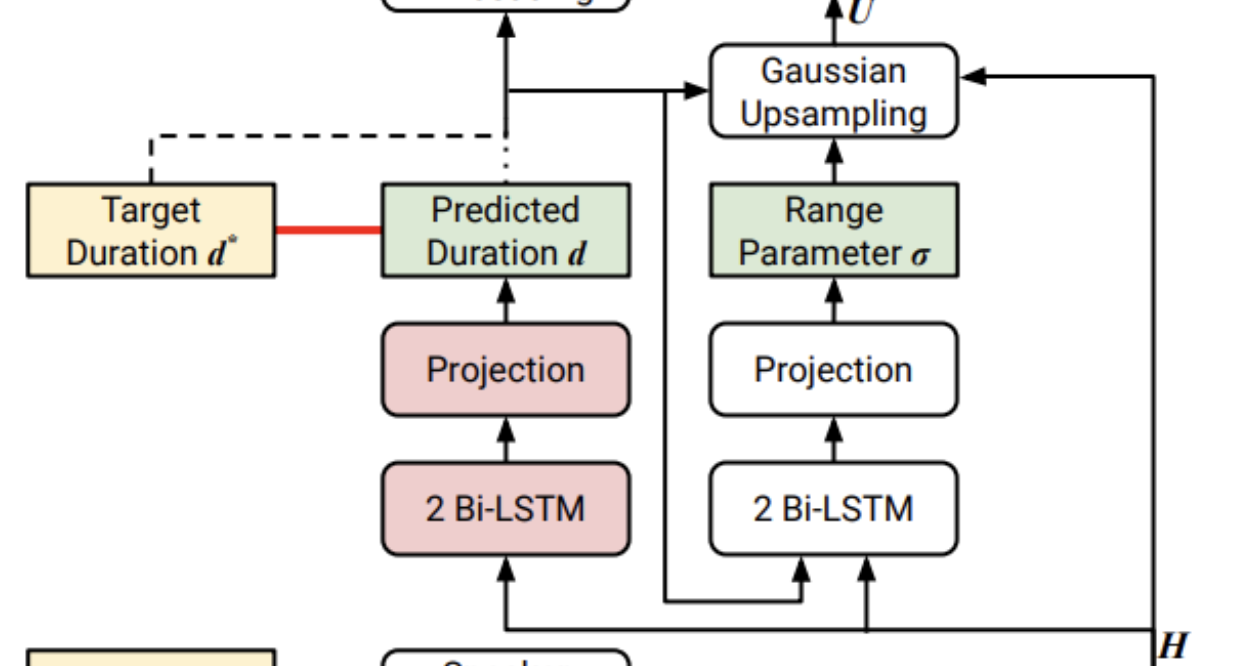

In [160]:
Image('imgs/dp_detailed.png', width=600)

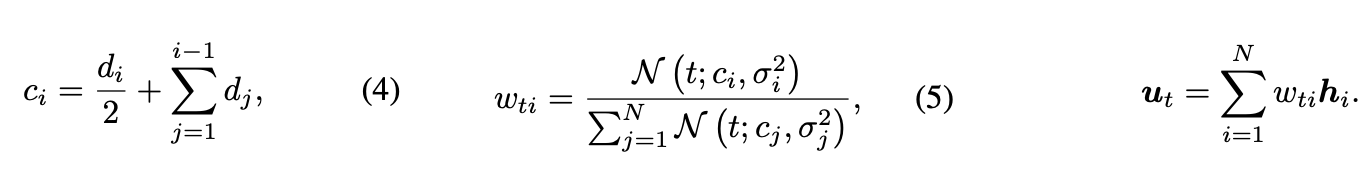

In [161]:
Image('imgs/gaussian_upsampling.png', width=650)

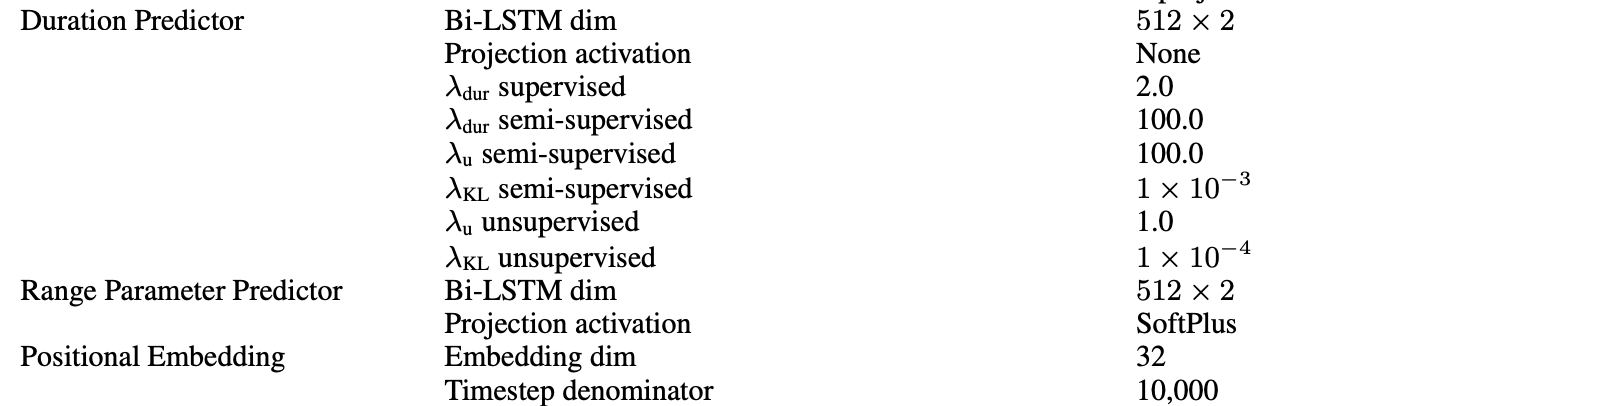

In [162]:
Image('imgs/dp.png', width=700)

In [163]:
cfg.duration_lstm_dim = 512*2
cfg.range_lstm_dim = 512*2


### 2.1 Durations and Ranges prediction

In [164]:
class DurationPredictor(nn.Module):
    """Duration Predictor module:
        - two stack of BiLSTM
        - one projection layer
    """
    def __init__(self, cfg):
        super(DurationPredictor, self).__init__()

        self.lstm = nn.LSTM(cfg.encoder_lstm_dim,
                            int(cfg.duration_lstm_dim/2), 2,
                            batch_first=True, bidirectional=True)

        self.proj = LinearNorm(cfg.duration_lstm_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, encoder_outputs, input_lengths=None):
        """
            :param encoder_outputs: [B, N, encoder_lstm_dim]
            :param input_lengths: [B]
            :return: [B, N]
        """

        B = encoder_outputs.size(0)
        N = encoder_outputs.size(1)

        ## remove pad activations
        if input_lengths is not None:
            encoder_outputs = pack_padded_sequence(
                encoder_outputs, input_lengths, batch_first=True, enforce_sorted=False)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(encoder_outputs)

        if input_lengths is not None:
            outputs, _ = pad_packed_sequence(
                outputs, batch_first=True)

        outputs = self.relu(self.proj(outputs))

        return outputs.view(B, N)

class RangePredictor(nn.Module):
    """Duration Predictor module:
        - two stack of BiLSTM
        - one projection layer
    """
    def __init__(self, cfg):
        super(RangePredictor, self).__init__()
        assert cfg.range_lstm_dim%2==0, "range_lstm_dim must be even [{}]".format(cfg.range_lstm_dim)

        self.lstm = nn.LSTM(cfg.encoder_lstm_dim + 1,
                            int(cfg.range_lstm_dim/2), 2,
                            batch_first=True, bidirectional=True)

        self.proj = LinearNorm(cfg.range_lstm_dim, 1)

    def forward(self, encoder_outputs, durations, input_lengths=None):
        """
            :param encoder_outputs:
            :param durations:
            :param input_lengths:
            :return:
        """


        concated_inputs = torch.cat([encoder_outputs, durations.unsqueeze(-1)], dim=-1)

        ## remove pad activations
        if input_lengths is not None:
            concated_inputs = pack_padded_sequence(
                concated_inputs, input_lengths, batch_first=True, enforce_sorted=False)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(concated_inputs)

        if input_lengths is not None:
            outputs, _ = pad_packed_sequence(
                outputs, batch_first=True)

        outputs = self.proj(outputs)
        outputs = F.softplus(outputs)
        return outputs.squeeze()

In [168]:
dp = DurationPredictor(cfg)
rp = RangePredictor(cfg)

durations_pred = dp(encoder_outputs, input_lengths)

ranges_pred = rp(encoder_outputs, durations_pred) #target durations during inference

In [169]:
print(f"Predicted durations shape: {durations_pred.shape}")
print(f"Predicted ranges shape: {ranges_pred.shape}")

Predicted durations shape: torch.Size([4, 30])
Predicted ranges shape: torch.Size([4, 30])


In [170]:
durations_pred[0]

tensor([0.0548, 0.0687, 0.0768, 0.0763, 0.0838, 0.0823, 0.0820, 0.0789, 0.0683,
        0.0674, 0.0504, 0.0466, 0.0340, 0.0236, 0.0065, 0.0002, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], grad_fn=<SelectBackward0>)

In [171]:
ranges_pred[0]

tensor([0.6977, 0.6971, 0.6962, 0.6977, 0.7067, 0.7136, 0.7154, 0.7209, 0.7227,
        0.7229, 0.7267, 0.7245, 0.7219, 0.7141, 0.7068, 0.7069, 0.7052, 0.7041,
        0.7029, 0.7019, 0.7011, 0.7005, 0.7001, 0.6998, 0.6996, 0.6993, 0.6988,
        0.6979, 0.6964, 0.6939], grad_fn=<SelectBackward0>)

### 2.2 Upsampling

In [172]:
class GaussianUpsampling(nn.Module):
    """
        Non-attention Tacotron:
            - https://arxiv.org/abs/2010.04301
        this source code is implemenation of the ExpressiveTacotron from BridgetteSong
            - https://github.com/BridgetteSong/ExpressiveTacotron/blob/master/model_duration.py
    """
    def __init__(self):
        super(GaussianUpsampling, self).__init__()
        self.mask_score = -1e15

    def forward(self, encoder_outputs, durations, vars, input_lengths=None):
        """ Gaussian upsampling
        PARAMS
        ------
        encoder_outputs: Encoder outputs  [B, N, encoder_dim]
        durations: phoneme durations  [B, N]
        vars : phoneme attended ranges [B, N]
        input_lengths : [B]
        RETURNS
        -------
        encoder_upsampling_outputs: upsampled encoder_output  [B, T, encoder_dim]
        """
        B = encoder_outputs.size(0)
        N = encoder_outputs.size(1)
        T = int(torch.sum(durations, dim=1).max().item()) #number of frames
        c = torch.cumsum(durations, dim=1).float() - 0.5 * durations
        c = c.unsqueeze(2) # [B, N, 1]
        t = torch.arange(T, device=encoder_outputs.device).expand(B, N, T).float()  # [B, N, T]
        vars = vars.view(B, -1, 1) # [B, N, 1]


        w_t = -0.5 * (np.log(2.0 * np.pi) + torch.log(vars) + torch.pow(t - c, 2) / vars) # [B, N, T]

        if input_lengths is not None:
            input_masks = ~self.get_mask_from_lengths(input_lengths, N) # [B, N]
            input_masks = torch.tensor(input_masks, dtype=torch.bool, device=w_t.device)
            masks = input_masks.unsqueeze(2)
            w_t.data.masked_fill_(masks, self.mask_score)
        w_t = F.softmax(w_t, dim=1)

        encoder_upsampling_outputs = torch.bmm(w_t.transpose(1, 2), encoder_outputs)  # [B, T, encoder_hidden_size]

        return encoder_upsampling_outputs
    

    def get_mask_from_lengths(self, lengths, max_len=None):
        if max_len is None:
            max_len = max(lengths)
        ids = np.arange(0, max_len)
        mask = (ids < lengths.reshape(-1, 1))
        return mask

In [173]:
upsamling = GaussianUpsampling()

In [174]:
#inference
upsampled_encoder_output = upsamling(encoder_outputs, durations_pred, ranges_pred, input_lengths.numpy())
print(f"Upsampled encoder output shape: {upsampled_encoder_output.shape}")

Upsampled encoder output shape: torch.Size([4, 1, 1024])


In [175]:
print(torch.sum(durations_pred, dim=1))

tensor([0.9005, 0.0145, 1.0525, 1.1271], grad_fn=<SumBackward1>)


In [176]:
int(torch.sum(durations_pred, dim=1).max().item())

1

In [177]:
gt_durations = torch.LongTensor([[3,4,5,6,1,7,8,9,4,10,11,1,5,2,5,7,8,3,7,4,5,6,6,2,5,1,3,5,3, 4],
                                 [3,4,5,6,1,7,8,9,4,10,11,1,5,2,5,7,8,3,7,4,5,6,6,2,5,1,3,5,3, 4],
                                 [3,4,5,6,1,7,8,9,4,10,11,1,5,2,5,7,8,3,7,4,5,6,6,2,5,1,3,5,3, 4],
                                 [3,4,5,6,1,7,8,9,4,10,11,1,5,2,5,7,8,3,7,4,5,6,6,2,5,1,3,5,3, 4]
                                ])
gt_durations.shape, gt_durations[0].sum()


encoder_upsampled_output = upsamling(encoder_outputs, gt_durations, ranges_pred, input_lengths.numpy())
print(f"Upsampled encoder output shape: {encoder_upsampled_output.shape}")

Upsampled encoder output shape: torch.Size([4, 150, 1024])


# 3. Decoder

**Input** (upsamples_encoder_output+PE):  concat([$U$,  PE]), **shape**:  (bs x frames_num x encoder_hidden_dim+pe_dim)


**Output** (decoder output): $Y'$ = ($Y'_1$, $Y'_2$, ..., $Y'_{frames\_num}$), **shape**:  (bs x frames_num x mel_bins)

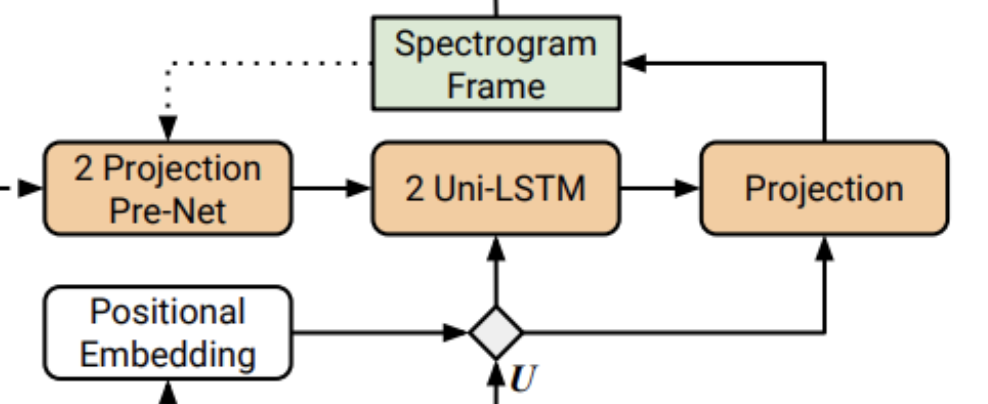

In [178]:
Image('imgs/decoder_detailed.png', width=600)

### 3.1 Positional encoding

*The positional embedding tracks the index of each upsampled frame within each token; if the duration values
are [2, 1, 3], the indices for the positional embedding would be [1, 2, 1, 1, 2, 3].*

In [179]:
cfg.positional_embedding_dim = 32

In [180]:
class PositionalEncoding(nn.Module):
    """
        sinusoidal positional encoding
        https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[x]
    
def get_positional_embedding(durations, positional_embedding):
        """
            :param durations: [B, N]
            :return positional_embedding_outputs: [B, T, positional_hidden]
        """

        B = durations.size(0)
        N = durations.size(1)

        pos_durations = durations.long()
        sum_len = pos_durations.sum(dim=1)
        max_len = sum_len.max()
        diff_len = max_len - sum_len
        pos_durations[:, -1] = pos_durations[:, -1] + diff_len

        ids = torch.arange(max_len, device=durations.device).expand(B, N, max_len)
        pos_mask = (ids < pos_durations.view(B, N, 1))
        pos_ids = ids[pos_mask].view(-1, max_len)  # [B, T]
        positional_embedding_outputs = positional_embedding(pos_ids)

        return positional_embedding_outputs

In [181]:
positional_embedding = PositionalEncoding(cfg.positional_embedding_dim)

positional_embedding_outputs = get_positional_embedding(gt_durations, positional_embedding)
encoder_concated_outputs = torch.cat([encoder_upsampled_output, positional_embedding_outputs], dim=2)

print(f"Positional embedding outputs shape: {positional_embedding_outputs.shape}")
print(f"Encoder concated outputs shape: {encoder_concated_outputs.shape}")

Positional embedding outputs shape: torch.Size([4, 150, 32])
Encoder concated outputs shape: torch.Size([4, 150, 1056])


### 3.2 Decoder

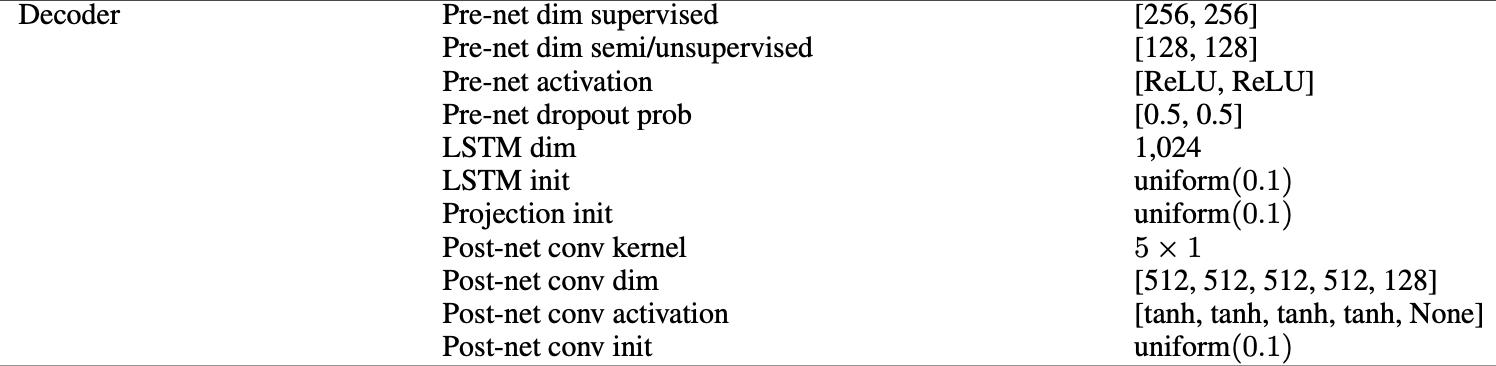

In [182]:
Image('imgs/decoder.png', width=600)

In [ ]:
cfg.n_mel_channels = 80
cfg.decoder_lstm_dim = 1024
cfg.decoder_lstm_n = 2
cfg.decoder_dropout_p = 0.1
cfg.prenet_dim = 256
cfg.prenet_dropout_p = 0.5
cfg.prenet_activation = "relu"


In [ ]:
class Prenet(nn.Module):
    def __init__(self, in_dim, sizes, dropout_p=0.5, activation='relu'):
        super(Prenet, self).__init__()

        in_sizes = [in_dim] + sizes[:-1]
        self.layers = nn.ModuleList(
                [LinearNorm(in_size, out_size, bias=False)
                for (in_size, out_size) in zip(in_sizes, sizes)])

        self.dropout = nn.Dropout(p=dropout_p)
        self.activation = nn.ReLU()

    def forward(self, x):
        for linear in self.layers:
            x = self.dropout(self.activation(linear(x)))
        return x

class Decoder(nn.Module):
    """Decoder module:
        - Three (dropout, batch normalization, convolution)
        - single Bidirectional LSTM
    """

    def __init__(self, cfg):
        super(Decoder, self).__init__()
        ## decoder

        self.n_mel_channels = cfg.n_mel_channels
        self.decoder_lstm_dim = cfg.decoder_lstm_dim
        self.decoder_lstm_n = cfg.decoder_lstm_n

        self.prenet = Prenet(
            cfg.n_mel_channels,
            [cfg.prenet_dim, cfg.prenet_dim],
            dropout_p=cfg.prenet_dropout_p,
            activation=cfg.prenet_activation
        )

        self.decoder_lstm = nn.LSTM(
            input_size=cfg.prenet_dim + cfg.encoder_lstm_dim + cfg.positional_embedding_dim,
            hidden_size=cfg.decoder_lstm_dim,
            num_layers=cfg.decoder_lstm_n,
            batch_first=True,
            dropout=cfg.decoder_dropout_p,
        )

        self.linear_projection = LinearNorm(
            cfg.decoder_lstm_dim + cfg.encoder_lstm_dim + cfg.positional_embedding_dim,
            cfg.n_mel_channels)

    def forward(self, encoder_concated_outputs, durations, mel_specs): #gt durations, mels
        """ Prepares decoder inputs, i.e. mel outputs
            PARAMS
            ------
            encoder_concated_outputs: [B, T, encoder_lstm_dim + positional_embedding_dim]
            input_lengths : [B]
            mel_specs : [B, n_mel_channels, T]
            mel_length : [B]

            RETURNS
            -------
            predicted_mel_specs: processed decoder mel_specs

        """

        B = encoder_concated_outputs.size(0)

        # [B, n_mel_channels, T-1]
        guided_mel_specs = mel_specs[:, :, :-1]

        ## dummy mel_spec input must be zeors
        dummy_spec = torch.zeros(B, self.n_mel_channels, 1, device=guided_mel_specs.device)  # [B, n_mel_channels, 1]

        guided_mel_specs = torch.cat([dummy_spec, guided_mel_specs], dim=2)  # [B, n_mel_channels, T]

        # [B, n_mel_channels, T] -> [B, T, n_mel_channels]
        guided_mel_specs = guided_mel_specs.transpose(1, 2)

        prenet_outputs = self.prenet(guided_mel_specs) # [B, T, prenet_dim]

        concated_prenet_outputs = torch.cat([prenet_outputs, encoder_concated_outputs], dim=2)

        ## remove pad activations

        concated_prenet_outputs = pack_padded_sequence(
            concated_prenet_outputs, durations.long().sum(dim=1).detach().cpu(), batch_first=True, enforce_sorted=False)

        self.decoder_lstm.flatten_parameters()
        decoder_lstm_outputs, _ = self.decoder_lstm(concated_prenet_outputs) # [B, T, decoder_lstm_dim]

        decoder_lstm_outputs, _ = pad_packed_sequence(
            decoder_lstm_outputs, batch_first=True)

        concated_decoder_lstm_outputs = torch.cat([decoder_lstm_outputs, encoder_concated_outputs], dim=2) # [B, T, decoder_lstm_dim + encoder_lstm_dim + positional_embedding_dim]

        predicted_mel_specs = self.linear_projection(concated_decoder_lstm_outputs) # [B, T, n_mel_channels]
        predicted_mel_specs = predicted_mel_specs.transpose(1, 2) # [B, n_mel_channels, T]

        return predicted_mel_specs
    

    def inference(self, encoder_concated_outputs, durations):
        """ Prepares decoder inputs, i.e. mel outputs
            PARAMS
            ------
            encoder_concated_outputs: [B, T, encoder_lstm_dim + positional_embedding_dim]
            input_lengths : [B, N]
            mel_specs : [B, n_mel_channels, T]
            mel_length : [B, ]

            RETURNS
            -------
            predicted_mel_specs: processed decoder mel_specs

        """

        B = encoder_concated_outputs.size(0)

        ## total mel length to generate
        total_length = durations.long().sum(dim=1).max()

        ## initialization
        ## 1. first mel_spec input must be zeors [B, 1, n_mel_channels]
        predicted_mel_spec = torch.zeros(B, 1, self.n_mel_channels, device=encoder_concated_outputs.device)
        ## 2. decoder_lstm_hidden, decoder_lstm_cell
        decoder_lstm_hidden = torch.zeros(self.decoder_lstm_n, B, self.decoder_lstm_dim, device=encoder_concated_outputs.device)
        decoder_lstm_cell = torch.zeros(self.decoder_lstm_n, B, self.decoder_lstm_dim, device=encoder_concated_outputs.device)

        predicted_mel_specs = []
        for idx in range(total_length):
            prenet_output = self.prenet(predicted_mel_spec)  # [B, 1, prenet_dim]
            encoder_concated_output = encoder_concated_outputs[:, idx, :].unsqueeze(1)
            concated_prenet_output = torch.cat([prenet_output, encoder_concated_output], dim=2) # [B, 1, decoder_lstm_dim + encoder_lstm_dim + positional_embedding_dim]
            self.decoder_lstm.flatten_parameters()

            # decoder_lstm_output: [B, 1, decoder_lstm_dim]
            decoder_lstm_output, (decoder_lstm_hidden, decoder_lstm_cell) = self.decoder_lstm(concated_prenet_output, (decoder_lstm_hidden, decoder_lstm_cell))

            # concated_decoder_lstm_output : [B, 1, decoder_lstm_dim + encoder_lstm_dim + positional_embedding_dim]
            concated_decoder_lstm_output = torch.cat([decoder_lstm_output, encoder_concated_output], dim=2)

            predicted_mel_spec = self.linear_projection(concated_decoder_lstm_output)  # [B, 1, n_mel_channels]
            predicted_mel_specs.append(predicted_mel_spec)

        # predicted_mel_specs : [B, T, n_mel_channels]
        predicted_mel_specs = torch.cat(predicted_mel_specs, dim=1)
        predicted_mel_specs = predicted_mel_specs.transpose(1, 2)  # [B, n_mel_channels, T]

        return predicted_mel_specs

    


In [192]:
decoder = Decoder(cfg)

In [193]:
gt_mels = torch.rand((bs, cfg.n_mel_channels, gt_durations[0].sum()))
gt_mels.shape

torch.Size([4, 80, 150])

In [194]:
mels_pred1 = decoder(encoder_concated_outputs, gt_durations, gt_mels)
print(f"Spectrogram after decoder shape: {mels_pred1.shape}")

Spectrogram after decoder shape: torch.Size([4, 80, 150])


# 4. Postnet

**Input** (decoder_output):  $Y'$ = ($Y'_1$, $Y'_2$, ..., $Y'_{frames\_num}$), **shape**:  (bs x frames_num x mel_bins)


**Output** (postnet output): $Y$ = ($Y_1$, $Y_2$, ..., $Y_{frames\_num}$), **shape**:  (bs x frames_num x mel_bins)

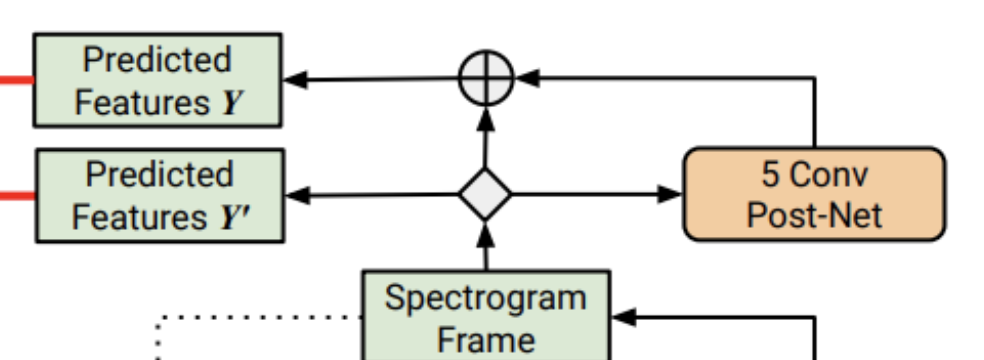

In [187]:
Image('imgs/postnet_detailed.png', width=600)

In [195]:
cfg.postnet_activation = 'tanh'
cfg.postnet_dropout_p = 0.5
cfg.postnet_embedding_dim = 512
cfg.postnet_kernel_size = 5
cfg.postnet_n_convolutions = 5

In [189]:
class Postnet(nn.Module):
    """Postnet
        - Five 1-d convolution with 512 channels and kernel size 5
    """

    def __init__(self, cfg):
        super(Postnet, self).__init__()

        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(p=cfg.postnet_dropout_p)

        self.convolutions = nn.ModuleList()
        self.convolutions.append(
            nn.Sequential(
                ConvNorm(cfg.n_mel_channels, cfg.postnet_embedding_dim,
                         kernel_size=cfg.postnet_kernel_size, stride=1,
                         padding=int((cfg.postnet_kernel_size - 1) / 2),
                         dilation=1, w_init_gain=cfg.postnet_activation),
                nn.BatchNorm1d(cfg.postnet_embedding_dim))
        )

        for i in range(1, cfg.postnet_n_convolutions - 1):
            self.convolutions.append(
                nn.Sequential(
                    ConvNorm(cfg.postnet_embedding_dim,
                             cfg.postnet_embedding_dim,
                             kernel_size=cfg.postnet_kernel_size, stride=1,
                             padding=int((cfg.postnet_kernel_size - 1) / 2),
                             dilation=1, w_init_gain=cfg.postnet_activation),
                    nn.BatchNorm1d(cfg.postnet_embedding_dim))
            )

        self.convolutions.append(
            nn.Sequential(
                ConvNorm(cfg.postnet_embedding_dim, cfg.n_mel_channels,
                         kernel_size=cfg.postnet_kernel_size, stride=1,
                         padding=int((cfg.postnet_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='linear'),
                nn.BatchNorm1d(cfg.n_mel_channels))
            )

    def forward(self, x):
        for i in range(len(self.convolutions) - 1):
            x = self.dropout(self.activation(self.convolutions[i](x)))
        x = self.dropout(self.convolutions[-1](x))

        return x

In [196]:
postnet = Postnet(cfg)

mels_pred_final = postnet(mels_pred1)
print(f"Spectrogram after postnet shape: {mels_pred_final.shape}")

Spectrogram after postnet shape: torch.Size([4, 80, 150])


# Training

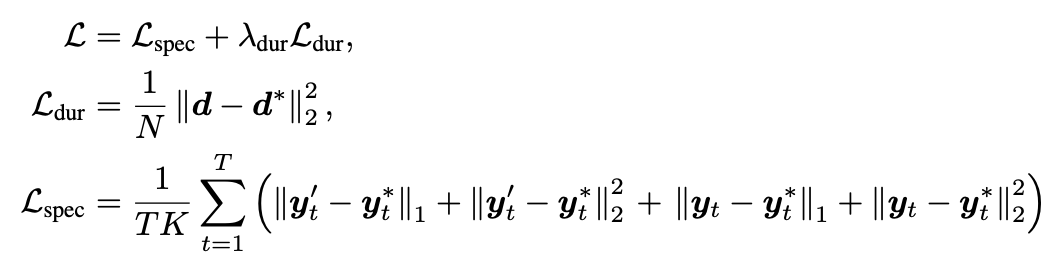

In [191]:
Image('imgs/loss.png', width=600)


Data:
   - **tokenized text**

   - **mel-spectrograms** (suitable for the vocoder!!!)

   - **GT durations**


Useful aligner tool: https://montreal-forced-aligner.readthedocs.io/en/latest/

# In paper

**Dataset** (proprietary):  354 hours, 66 speakers in 4 English accents 

**Vocoder**: WaveRNN

## MOS

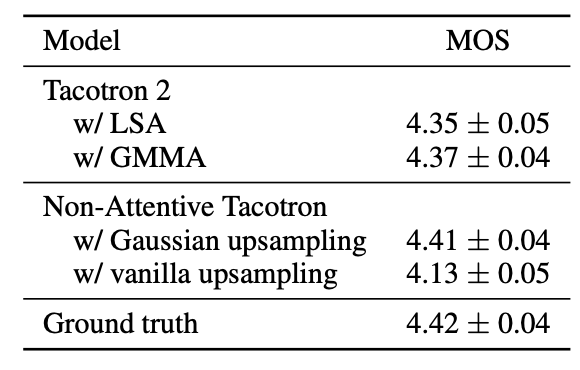

In [197]:
Image('imgs/mos.png', width=300)


## Robustness

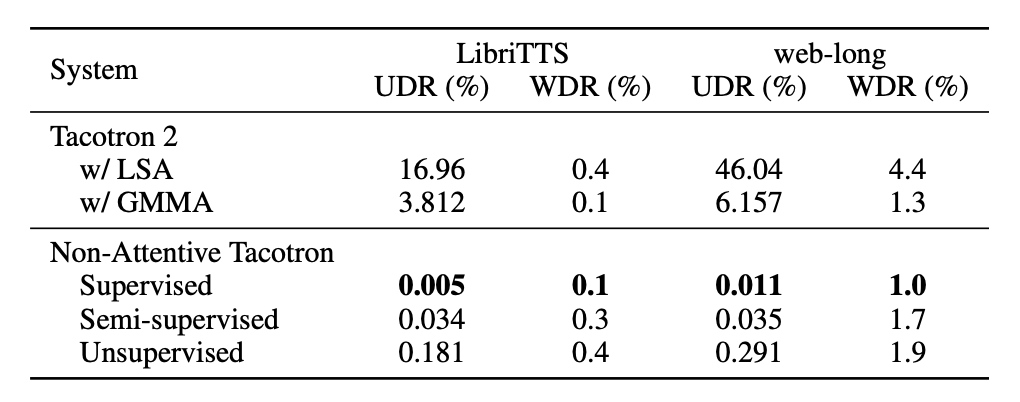

In [198]:
Image('imgs/robustness.png', width=500)

## Pace control

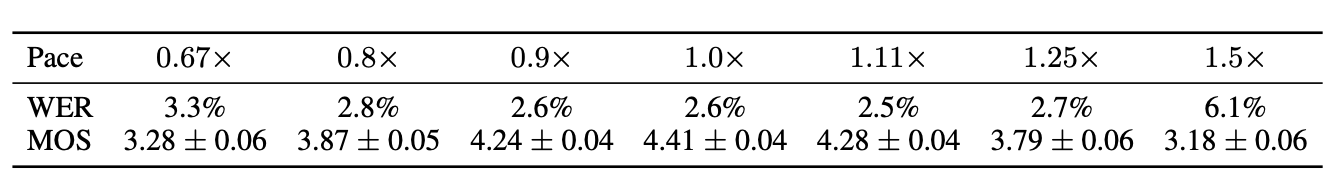

In [201]:
Image('imgs/pace_control1.png', width=700)

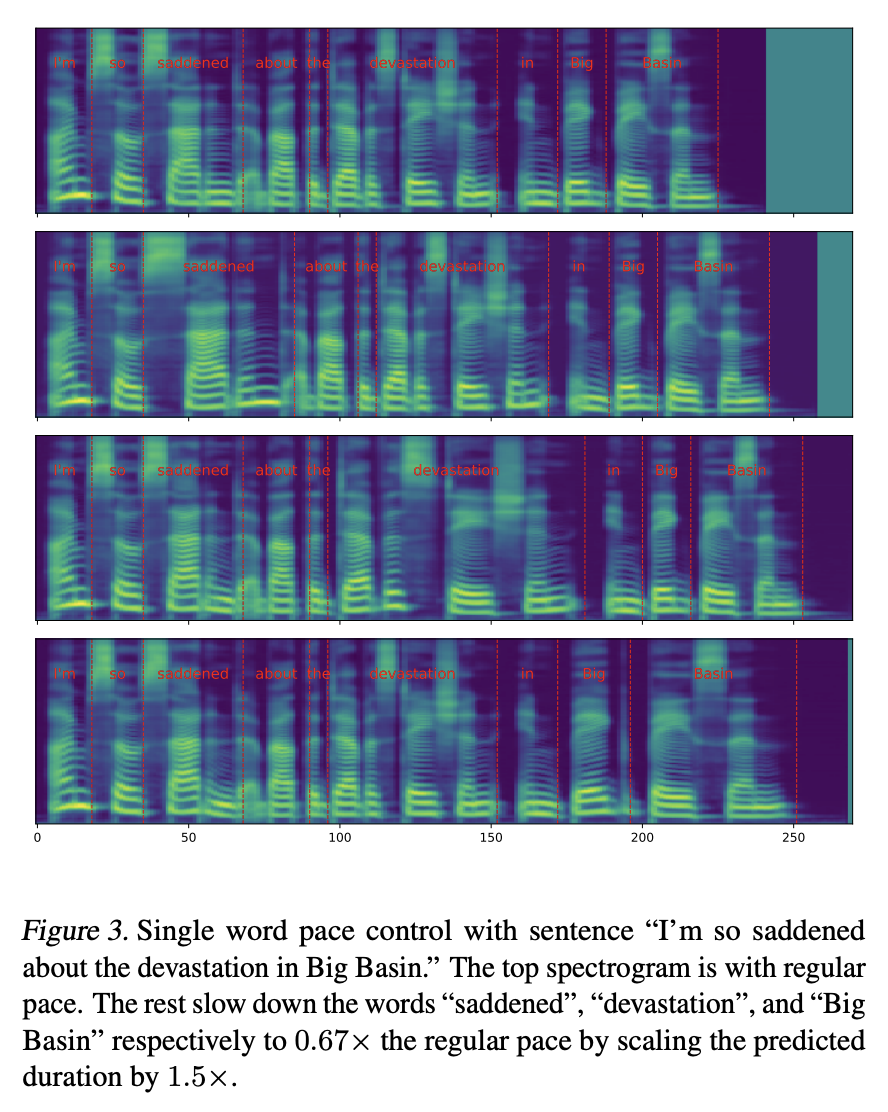

In [202]:
Image('imgs/pace_control2.png', width=600)

# Demo page

https://google.github.io/tacotron/publications/nat/

# Popular datasets

->